## OVERVIEW

This notebook servers as a workbook for modeling. Various hyperparameters are tested and tuned to find an optimal model. 

This notebook includes data cleaning and pre-processing from notebook 1. Data Wrangling to Modeling but excludes unnecessary graphics.

## 0. Import Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import imghdr
from matplotlib import pyplot as plt
import glob
from skimage import color, exposure

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping

#Establish Evaluation Functions
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

2023-05-10 22:13:50.073311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 0.1 Avoid OOM errors - limit tensorflow from using all of the vram on our machine.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    f.config.experimental.set_memory_growth(gpu, True)

## 1. Import Data

#### 1.1 Gather Data

Note, data from this project was provided directly from WindowsWear, a company that manages a database of retail images. These images were provided in high resolution quality but due to commercial interests, the company requested that only low resolution photos be used and published for this project.
Prior to import: these images were downloaded from dropbox, compressed to lower resolution using Adobe Bridge, and manually sorted into two folders - images containing mannequins and images not containing mannequins. 
This data is published on my github: https://github.com/chase-weber/Mannequin-Image-Detection

#### 1.2 Establish a Data Directory

In [3]:
# Establish data directory - data can be downloaded from my github - see above.
data_dir = '/Users/chaseweber/Desktop/Springboard/Github/Mannequin-Image-Detection/data'

# Establish acceptable image formats
image_ext = ['jpeg', 'jpg']

In [4]:
# Check data directory - list of folders should be listed
os.listdir(data_dir)

## In some cases, apple includes a '.DS_Store' in the data folder. Use terminal to navigate to the data folder and use the code below to delete. 
# find . -name '.DS_Store' -type f -delete 

['mannequin', '.DS_Store', 'other']

In [5]:
# List the images in each folder
# os.listdir(os.path.join(data_dir, 'other'))

#### 1.3 Check Images

In [6]:
img = cv2.imread(os.path.join(data_dir, 'other', 'image_000013.jpeg'))

In [7]:
img.shape

(300, 200, 3)

#### 1.4 Load Data

In [8]:
# Explore the documentation for tf.keras.utils.image_dataset_from_directory
#tf.keras.utils.image_dataset_from_directory??

In [9]:
# Use keras to create an image dataset
## Batch size of 32 - default
## Size 300, 300
## Grayscale
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 10, color_mode = 'grayscale', image_size = (300, 300))

Found 4912 files belonging to 2 classes.


In [10]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### 1.5 Use Numpy Iterator to Iterate through Images

In [11]:
# Initiate iterator to explore imported data
# NOTE: data is actually a data generator, an iterator is required to access the data.
data_iterator = data.as_numpy_iterator()

In [12]:
# Create batch that iterates through our data
batch = data_iterator.next()
# batch

In [13]:
len(data)

492

In [14]:
# Notice there are two parts, and image part and a label part
len(batch)

2

In [15]:
# Images represented as Numpy Arrays
batch[0].shape

(10, 300, 300, 1)

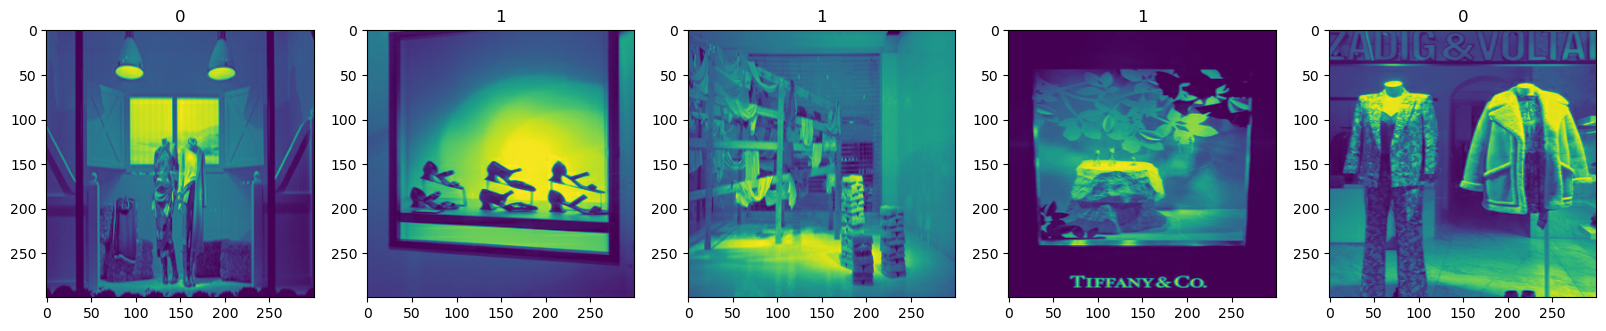

In [16]:
# Determine which label class represents which photo class
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Based on the above, we see that 0 represents cases with mannequins while 1 represents cases without mannequins. 
Images are imported as black and white.

## 2. Additional Data Manipulations

#### 2.1 Scale Images
#### Ensure that all images are scaled between 0 and 1

In [17]:
data2 = data.map(lambda x,y: (x/300, y))

#### 2.2 Sharpen Images
#### Increase the contrast in each image to better capture presense of mannequin

In [18]:
data2 = data2.map(lambda x,y: (tf.image.adjust_contrast(x, .7), y))

#### 2.3 Crop Images
#### Crop to images to about 85% of the original width and 90% of the original height to avoid unnecessary noise 

In [19]:
data2 = data2.map(lambda x,y: (tf.image.crop_to_bounding_box(x, 10, 20, 250, 220), y))

#### 2.4 Random Flip Images
#### Apply a random vertical flip to each image to create a more diverse dataset

In [20]:
data2 = data2.map(lambda x,y: (tf.image.random_flip_left_right(x, 123), y))

#### 2.5 Shuffle Data

In [21]:
data2 = data2.shuffle(10, seed=123, reshuffle_each_iteration=None)

## 3. Exploratory Data Analysis

#### 3.1 Is our data imballanced?

In [22]:
number_classes = {'Class_Mannequin': len(os.listdir(os.path.join(data_dir, 'mannequin'))),
                 'Class_Other': len(os.listdir(os.path.join(data_dir, 'other')))}

In [23]:
number_classes.values()

dict_values([2499, 2413])

Based on the counts above, there doesn't appear to be too much of an imballance in our data.

#### 3.2 Show examples of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGES BEFORE CLEANING: 


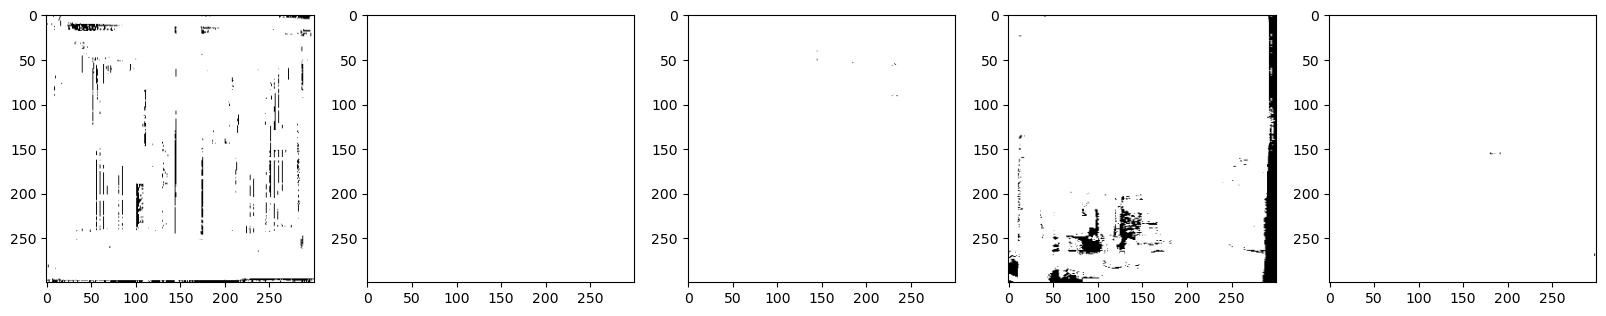

In [24]:
# Print out images for display
print("IMAGES BEFORE CLEANING: ")
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    #ax[idx].imshow(img)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

IMAGES AFTER CLEANING: 


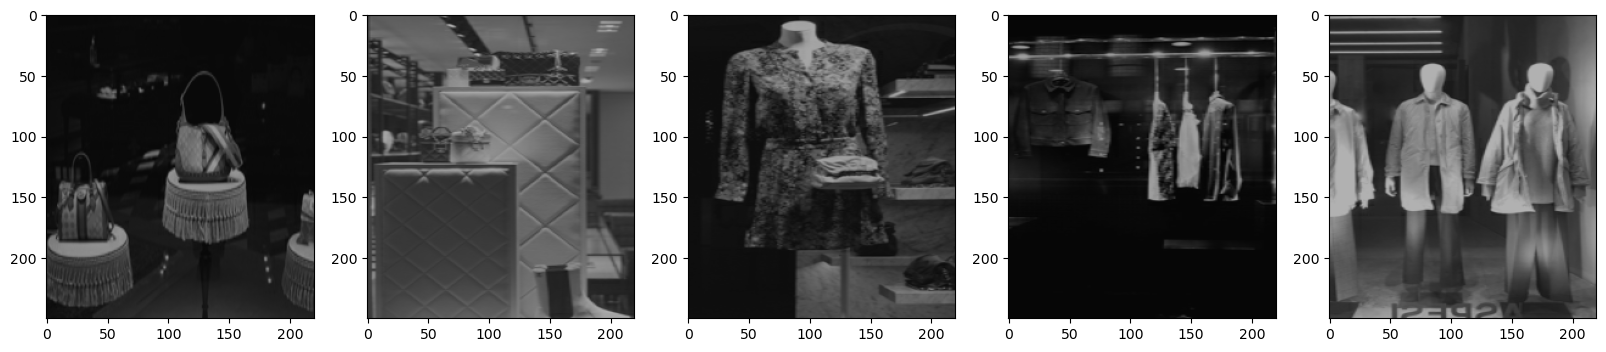

In [25]:
# Show enhanced and cropped images
print("IMAGES AFTER CLEANING: ")
data_iterator = data2.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    #ax[idx].imshow(img)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 4. Pre-Processing

#### 4.1 Split the data

In [26]:
# Establish Size of Training, Test, and Validation splits
print(len(data2))
train_size = int(len(data2) * .7)
val_size = int(len(data2) * .2)
test_size = int(len(data2) * .1)
print(train_size)
print(val_size)
print(test_size)

492
344
98
49


In [27]:
# Create train, val, and test sets
train = data2.take(train_size)
val = data2.skip(train_size).take(val_size)
test = data2.skip(train_size+val_size).take(test_size)

In [28]:
# Check the length of the test set
len(test)

49

# 5. Model Training

#### 5.1 Establish an initial model 

In [29]:
model = Sequential()
model.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))

model.add(Conv2D(32, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [30]:
# Fit model
hist_initial = model.fit(train, validation_data=val, epochs = 5)

Epoch 1/5
344/344 [==============================] - 47s 135ms/step - loss: 0.7477 - accuracy: 0.6064 - val_loss: 0.6946 - val_accuracy: 0.6408
Epoch 2/5
344/344 [==============================] - 95s 276ms/step - loss: 0.5863 - accuracy: 0.7044 - val_loss: 0.6007 - val_accuracy: 0.6949
Epoch 3/5
344/344 [==============================] - 121s 351ms/step - loss: 0.4793 - accuracy: 0.7805 - val_loss: 0.5386 - val_accuracy: 0.7520
Epoch 4/5
344/344 [==============================] - 98s 285ms/step - loss: 0.3767 - accuracy: 0.8448 - val_loss: 0.5438 - val_accuracy: 0.7480
Epoch 5/5
344/344 [==============================] - 112s 324ms/step - loss: 0.2904 - accuracy: 0.8904 - val_loss: 0.6155 - val_accuracy: 0.7214


In [31]:
# Check test accuracy
check = model.evaluate(test)

49/49 [==============================] - 7s 80ms/step - loss: 0.7180 - accuracy: 0.6846


#### 5.2 Establish model with regularization
#### INCLUDE ADDITIONAL LAYER AND DROP OUT LAYERS

In [32]:
model = Sequential()
model.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [33]:
# Fit model
hist = model.fit(train, validation_data=val, epochs = 5)

Epoch 1/5
344/344 [==============================] - 70s 200ms/step - loss: 0.6720 - accuracy: 0.5788 - val_loss: 0.6300 - val_accuracy: 0.6714
Epoch 2/5
344/344 [==============================] - 66s 191ms/step - loss: 0.6126 - accuracy: 0.6640 - val_loss: 0.5834 - val_accuracy: 0.7327
Epoch 3/5
344/344 [==============================] - 68s 197ms/step - loss: 0.5593 - accuracy: 0.7122 - val_loss: 0.5701 - val_accuracy: 0.7143
Epoch 4/5
344/344 [==============================] - 67s 194ms/step - loss: 0.5130 - accuracy: 0.7442 - val_loss: 0.5268 - val_accuracy: 0.7673
Epoch 5/5
344/344 [==============================] - 72s 208ms/step - loss: 0.4765 - accuracy: 0.7782 - val_loss: 0.5033 - val_accuracy: 0.7714


In [34]:
# Check test accuracy
check = model.evaluate(test)

49/49 [==============================] - 5s 52ms/step - loss: 0.5504 - accuracy: 0.7282


#### 5.3 Establish model function with regularization
#### REMOVE EXCESS LAYERS AND INCLUDE DROP OUT LAYERS

In [35]:
model2 = Sequential()
model2.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))
model2.add(MaxPooling2D())
model2.add(Dropout(.25))

model2.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(.25))

model2.add(Flatten())

model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [36]:
# Fit model
hist = model.fit(train, validation_data=val, epochs = 5)

Epoch 1/5
344/344 [==============================] - 72s 209ms/step - loss: 0.4326 - accuracy: 0.8047 - val_loss: 0.4817 - val_accuracy: 0.7755
Epoch 2/5
344/344 [==============================] - 70s 203ms/step - loss: 0.3958 - accuracy: 0.8256 - val_loss: 0.5102 - val_accuracy: 0.7561
Epoch 3/5
344/344 [==============================] - 70s 204ms/step - loss: 0.3540 - accuracy: 0.8462 - val_loss: 0.4738 - val_accuracy: 0.7918
Epoch 4/5
344/344 [==============================] - 75s 218ms/step - loss: 0.3393 - accuracy: 0.8599 - val_loss: 0.4641 - val_accuracy: 0.7918
Epoch 5/5
344/344 [==============================] - 68s 198ms/step - loss: 0.3194 - accuracy: 0.8677 - val_loss: 0.4437 - val_accuracy: 0.8082


In [37]:
# Check test accuracy
check = model.evaluate(test)

49/49 [==============================] - 6s 54ms/step - loss: 0.5249 - accuracy: 0.7656


#### 5.4 Establish model function with regularization
#### ADD EVEN MORE LAYERS AND INCLUDE DROP OUT LAYERS

In [38]:
model = Sequential()
model.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [39]:
# Fit model
hist_initial = model.fit(train, validation_data=val, epochs = 8)

Epoch 1/8
344/344 [==============================] - 72s 204ms/step - loss: 0.6731 - accuracy: 0.5802 - val_loss: 0.7002 - val_accuracy: 0.5061
Epoch 2/8
344/344 [==============================] - 67s 193ms/step - loss: 0.6394 - accuracy: 0.6238 - val_loss: 0.6078 - val_accuracy: 0.6888
Epoch 3/8
344/344 [==============================] - 66s 191ms/step - loss: 0.5848 - accuracy: 0.6895 - val_loss: 0.5726 - val_accuracy: 0.7082
Epoch 4/8
344/344 [==============================] - 56s 162ms/step - loss: 0.5375 - accuracy: 0.7326 - val_loss: 0.5327 - val_accuracy: 0.7643
Epoch 5/8
344/344 [==============================] - 41s 120ms/step - loss: 0.5072 - accuracy: 0.7567 - val_loss: 0.5102 - val_accuracy: 0.7602
Epoch 6/8
344/344 [==============================] - 37s 107ms/step - loss: 0.5001 - accuracy: 0.7657 - val_loss: 0.5015 - val_accuracy: 0.7602
Epoch 7/8
344/344 [==============================] - 39s 113ms/step - loss: 0.4850 - accuracy: 0.7715 - val_loss: 0.5181 - val_accuracy:

In [40]:
# Check test accuracy
check = model.evaluate(test)

49/49 [==============================] - 7s 51ms/step - loss: 0.6043 - accuracy: 0.6743


#### 5.5 RUN PREVIOUS MODEL WITH MORE EPOCHS

In [41]:
model = Sequential()
model.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [42]:
# Fit model
hist_initial = model.fit(train, validation_data=val, epochs = 20)

Epoch 1/20
344/344 [==============================] - 76s 212ms/step - loss: 0.6619 - accuracy: 0.5907 - val_loss: 0.6670 - val_accuracy: 0.6245
Epoch 2/20
344/344 [==============================] - 62s 181ms/step - loss: 0.5968 - accuracy: 0.6817 - val_loss: 0.5824 - val_accuracy: 0.7388
Epoch 3/20
344/344 [==============================] - 75s 218ms/step - loss: 0.5329 - accuracy: 0.7352 - val_loss: 0.5363 - val_accuracy: 0.7622
Epoch 4/20
344/344 [==============================] - 73s 211ms/step - loss: 0.5236 - accuracy: 0.7503 - val_loss: 0.5422 - val_accuracy: 0.7408
Epoch 5/20
344/344 [==============================] - 76s 220ms/step - loss: 0.4913 - accuracy: 0.7698 - val_loss: 0.5149 - val_accuracy: 0.7480
Epoch 6/20
344/344 [==============================] - 69s 199ms/step - loss: 0.4845 - accuracy: 0.7701 - val_loss: 0.6278 - val_accuracy: 0.6276
Epoch 7/20
344/344 [==============================] - 71s 204ms/step - loss: 0.4666 - accuracy: 0.7776 - val_loss: 0.5364 - val_ac

In [43]:
# Check test accuracy
check = model.evaluate(test)

49/49 [==============================] - 3s 29ms/step - loss: 0.4500 - accuracy: 0.8071


# 6. Final Selected Model

Based on the results above, we select the final trained model. 5 Hidden layers with dropouts, maxpooling, relu activation, 16 - 32 alternating nodes, a final Dense layer with sigmoid activation, adam optimizer, and 20 epochs. 

# A. APPENDIX

#### The code below are provided as examples and references if needed

In [ ]:
# Define a function that will do all the preprocessing for each image to be ready for modeling

def image_preprocessing(path):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in path:
        # Firstly read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        img = cv2.bitwise_not(img)
        img = img/255

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [ ]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = Sequential()
# Add the first hidden layer
model.add(Conv2D(50, (2,2), 1, activation = 'sigmoid', input_shape = (280,260,1)))
# Add the second hidden layer
model.add(Dense(50, activation='relu'))
# Add the output layer
model.add(Dense(10, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

opt = SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
# Example of fit with EarlyStopping
hist_reg2 = model.fit(train, validation_data=val, epochs = 50, callbacks=EarlyStopping(monitor='val_loss'))